In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata.logging

import mubind.pl
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle
import seaborn
import numpy as np
import torch
import itertools
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

from pathlib import Path
from tqdm.notebook import tqdm_notebook as tqdm

Using device: cuda:0
Using device: cuda:0


In [3]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [4]:
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
if not os.path.exists(bd.constants.ANNOTATIONS_DIRECTORY):
    bd.constants.ANNOTATIONS_DIRECTORY = '.\\..\\..\\..\\..\\..\\..\\annotations'
os.path.exists(bd.constants.ANNOTATIONS_DIRECTORY)
print(bd.constants.ANNOTATIONS_DIRECTORY)
print(os.path.exists(bd.constants.ANNOTATIONS_DIRECTORY))

../../../annotations
True


In [5]:
pwms = mb.datasets.archetypes()
clu = mb.datasets.archetypes_clu()
anno = mb.datasets.archetypes_anno()


# motifs loaded 2179


The main motifs will be the seed ones

In [6]:

pwms_by_name = {}
for k, pwm in zip(anno['Seed_motif'], pwms):
    pwms_by_name[k] = pwm

reduced_groups = [p.to_numpy() for p in pwms]
len(reduced_groups)
# #
# # for pi, p in enumerate(reduced_groups):
#     print(pi, p.shape)

286

Layer with only scATAC-seq

In [7]:
drive = '/mnt/f/'
drive = '/mnt/f/' if os.path.exists(drive) else 'F:/'
print(drive)

/mnt/f/


In [8]:
h5ad_path = os.path.join(drive, 'workspace/theislab/mubind/data/gbm_multiome_scdori/23_01_23_atac_compressed.h5ad')
print(h5ad_path)


/mnt/f/workspace/theislab/mubind/data/gbm_multiome_scdori/23_01_23_atac_compressed.h5ad


In [9]:
ls -ltrh /mnt/f/workspace/theislab/mubind/data/gbm_multiome_scdori

total 59G
-rwxrwxrwx 1 rio rio  25G May  1 19:07 rna_27_11_22.h5ad*
-rwxrwxrwx 1 rio rio  34G May  2 15:02 23_01_23_atac_compressed.h5ad*
-rwxrwxrwx 1 rio rio 772K May  2 17:07 23_01_23_atac_compressed_n850.h5ad*
-rwxrwxrwx 1 rio rio 603K May  2 17:07 23_01_23_atac_compressed_n600.h5ad*
-rwxrwxrwx 1 rio rio 436K May  2 17:07 23_01_23_atac_compressed_n350.h5ad*
-rwxrwxrwx 1 rio rio 262K May  2 17:07 23_01_23_atac_compressed_n100.h5ad*
-rwxrwxrwx 1 rio rio 925M May 15 23:09 23_01_23_atac_compressed_n80000.h5ad*
-rwxrwxrwx 1 rio rio  18M May 15 23:45 23_01_23_atac_compressed_n10000.h5ad*
-rwxrwxrwx 1 rio rio 1.8M May 16 09:24 23_01_23_atac_compressed_n2000.h5ad*


In [10]:
import scanpy as sc
n_sample_cells = 350

bkp_path = os.path.join(h5ad_path.replace('.h5ad', '_n%i.h5ad' % n_sample_cells))
query_path = bkp_path if os.path.exists(bkp_path) else h5ad_path

print('trying to load...')
if not os.path.exists(query_path):
    print('reading main object...')
    adata_full = sc.read_h5ad(h5ad_path)
    print(adata_full.shape)
    for n_next_sample_cells in range(1000, 5000, 1000):
        bkp_path = os.path.join(h5ad_path.replace('.h5ad', '_n%i.h5ad' % n_next_sample_cells))
        if not os.path.exists(bkp_path):
            print(bkp_path)
            n_sample_peaks = int(n_next_sample_cells * 1.5)
            obs_sample = pd.Series(adata_full.obs_names).sample(n_next_sample_cells, random_state=n_next_sample_cells)
            var_sample = pd.Series(adata_full.var_names).sample(n_sample_peaks, random_state=n_next_sample_cells)
            # var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]
            ad = adata_full[adata_full.obs_names.isin(obs_sample), adata_full.var_names.isin(var_sample)].copy()
            print(ad.shape)
            ad.write(bkp_path, compression='lzf')
print('done. Attempting to load query object')
print(query_path)
adata_full = sc.read_h5ad(query_path)


trying to load...
done. Attempting to load query object
/mnt/f/workspace/theislab/mubind/data/gbm_multiome_scdori/23_01_23_atac_compressed_n350.h5ad


In [11]:
adata_full.shape

(350, 525)

For selection of features, adopt the accessibility score idea from EpiScanpy

In [12]:
acc = (adata_full.X != 0).sum(axis=0) / adata_full.shape[0]
acc_score = abs(.5 - acc)
adata_full.var['acc_score'] = acc_score.A.T
adata_full.var['acc_score_rank'] = adata_full.var['acc_score'].rank(ascending=False)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   2.,   1.,   0.,   2.,   2.,   2.,
          7.,   1.,   2.,   3.,   3.,   3.,   4.,   7.,   9.,  17.,  44.,
        112., 299.]),
 array([0.08857143, 0.10032653, 0.11208163, 0.12383673, 0.13559184,
        0.14734694, 0.15910204, 0.17085714, 0.18261224, 0.19436735,
        0.20612245, 0.21787755, 0.22963265, 0.24138776, 0.25314286,
        0.26489796, 0.27665306, 0.28840816, 0.30016327, 0.31191837,
        0.32367347, 0.33542857, 0.34718367, 0.35893878, 0.37069388,
        0.38244898, 0.39420408, 0.40595918, 0.41771429, 0.42946939,
        0.44122449, 0.45297959, 0.46473469, 0.4764898 , 0.4882449 ,
        0.5       ]),
 <BarContainer object of 35 artists>)

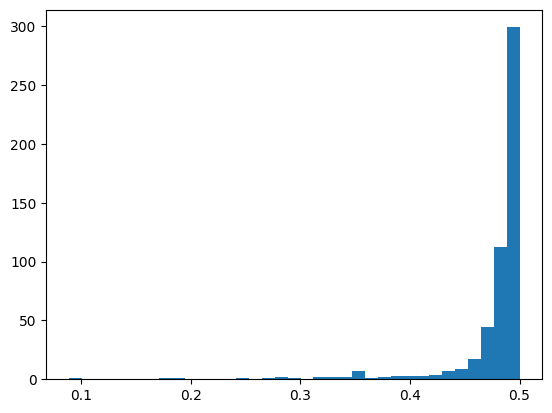

In [13]:
plt.hist(adata_full.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [14]:
adata_full.X = adata_full.X.astype('float32')

In [15]:
sc.pp.neighbors(adata_full, method='rapids')


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [16]:
sc.tl.umap(adata_full, method='rapids')

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


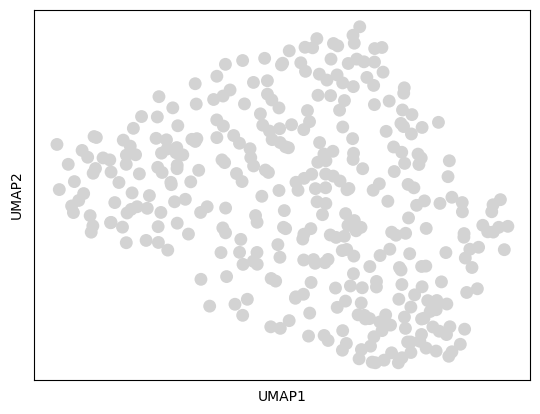

In [17]:
sc.pl.umap(adata_full)

In [18]:
# n_sample_cells = 500 # adata.shape[0]
# n_sample_peaks = n_sample_cells * 2 # adata.shape[1]

In [19]:
# adata = sc.pp.subsample(adata_full, n_obs=n_sample_cells, copy=True, random_state=100)
# print(adata.shape)
# var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)
# adata = adata[:,adata.var_names.isin(var_sample)].copy()
# print(adata.shape)
adata = adata_full

Normalize peak sequences into fixed lengths

In [20]:
adata.var['chr'] = adata.var['seqnames']
adata.var['k.summit'] = adata.var['chr'].astype(str) + ':' + adata.var['start'].astype(str) + '-' + adata.var['end'].astype(str)

Retrieve sequences

In [21]:
n_seqs = max(10000, adata.shape[1]) # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'start', 'end']].head(n_seqs), genome='hg38', uppercase=True)
                                            # gen_path='../../../annotations/dm6/genome/dm6.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

convert bed to fasta
/tmp/tmpvx2dqs7k
genome hg38 False
options
/mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
bedtools getfasta -fi /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmpvx2dqs7k -fo /tmp/tmp8odp_ztz
get fasta
/tmp/tmp8odp_ztz


Select peaks with non-zero counts

In [22]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.A.T

next_data = pd.DataFrame(counts)
next_data['var'] = next_data.var(axis=1)
next_data.index = [str(i) + '-' + s[1] for i, s in enumerate(seqs)]
next_data.index.name = 'seq'
print(next_data.shape)
n_cells = adata.shape[0]
n_peaks = adata.shape[1]
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_peaks]
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
del next_data_sel['var']
df = next_data_sel.copy() # sample
zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes
df.shape

print('# cells', n_cells)
print('# peaks', n_peaks)

print('selected', df.shape)

df.index = [v.split('-')[1] for v in df.index]
df.index.name = 'seq'

(525, 351)
# cells 350
# peaks 525
selected (482, 350)


### This is the relatedness graph and used for dynamics filters learning

In [23]:
adata.shape

(350, 525)

In [24]:
sc.pp.neighbors(adata, method='rapids')
ad = adata[:,~zero_counts].copy()

In [25]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))
n_batch = len(set(dataset.batch))
n_batch

train = tdata.DataLoader(dataset=dataset, batch_size=512 + 128, shuffle=True)


In [26]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [27]:
n_kernels = len(reduced_groups)
# n_kernels = 8

In [28]:
print('here...')

here...


In [29]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 150
show_conv = False
selected_groups = pwms[:50]

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in selected_groups]
    model = mb.models.Multibind.make_model(train,
                                           n_kernels,
                                           criterion, kernels=[0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(selected_groups):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    if show_conv:
        mb.pl.conv(model,
                title=False,
                xticks=False,
                rowspan_dinuc=0,
                rowspan_mono=1,
                n_rows=5,
                n_cols=12) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    if optimize_log_dynamic:
        model.selex_module.conn_sparse = torch.tensor(ad.uns['neighbors']['connectivities'].A).to_sparse().requires_grad_(True).cuda()
        model.selex_module.log_dynamic = tnn.Parameter(torch.rand(model.selex_module.conn_sparse.indices().shape[1])) # .cuda()
        model = model.cuda()
        model.selex_module.log_dynamic.shape

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1, optimiser=topti.Adam,
                                                skip_kernels=range(2, 500),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=1, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 150 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 1177.134644, R2: 0.09,  best epoch: 0,  secs per epoch: 6.507 s,  secs epoch*1k trials: 13.501s curr time: 2023-05-16 10:50:16.175700
Epoch:  3, Loss: 1109.134888, R2: 0.09,  best epoch: 1,  secs per epoch: 4.581 s,  secs epoch*1k trials: 9.503s curr time: 2023-05-16 10:50:18.829489
Epoch:  4, Loss: 1044.092041, R2: 0.09,  best epoch: 2,  secs per epoch: 4.054 s,  secs epoch*1k trials: 8.411s curr time: 2023-05-16 10:50:21.830384
Epoch:  5, Loss: 981.959595, R2: 0.10,  best epoch: 3,  secs per epoch: 3.813 s,  secs epoch*1k trials: 7.912s curr time: 2023-05-16 10:50:24.922066
Epoch:  6, Loss: 922.692688, R2: 0.10,  best epoch: 4,  secs per epoch: 3.659 s,  secs epoch*1k trials: 7.591s curr time

In [30]:
print('here...')

here...


True


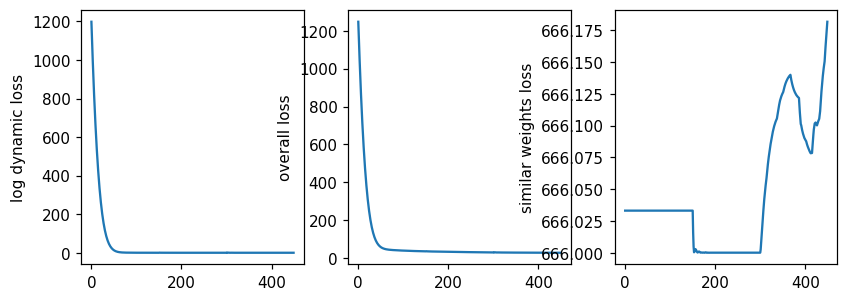

False


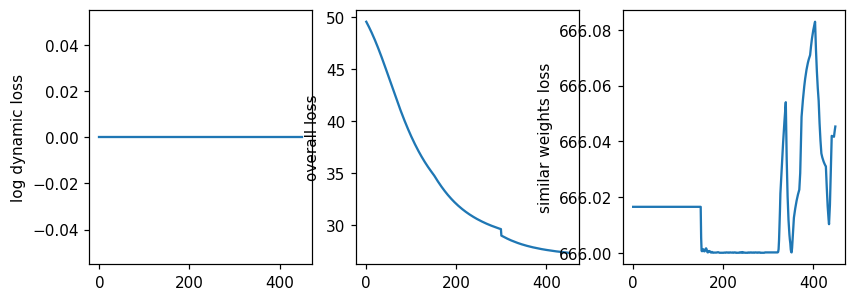

In [31]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    plt.subplot(1, 4, 1)
    plt.plot(model.loss_history_log_dynamic)
    plt.ylabel('log dynamic loss')
    plt.subplot(1, 4, 2)
    plt.plot(model.loss_history)
    plt.ylabel('overall loss')
    plt.subplot(1, 4, 3)
    plt.plot(model.loss_history_sym_weights)
    plt.ylabel('similar weights loss')
    plt.show()

True
True
8
0 out of 52...
8 8 0 (8, 8) (0, 0) 1
8 8 1 (8, 8) (0, 1) 1
8 8 2 (8, 8) (0, 2) 1
8 8 3 (8, 8) (0, 3) 1
8 8 4 (8, 8) (0, 4) 1
8 8 5 (8, 8) (0, 5) 1
8 8 6 (8, 8) (0, 6) 1
8 8 7 (8, 8) (1, 7) 1
8 8 0 (8, 8) (1, 0) 1
10 out of 52...
8 8 1 (8, 8) (1, 1) 1
8 8 2 (8, 8) (1, 2) 1
8 8 3 (8, 8) (1, 3) 1
8 8 4 (8, 8) (1, 4) 1
8 8 5 (8, 8) (1, 5) 1
8 8 6 (8, 8) (1, 6) 1
8 8 7 (8, 8) (2, 7) 1
8 8 0 (8, 8) (2, 0) 1
8 8 1 (8, 8) (2, 1) 1
8 8 2 (8, 8) (2, 2) 1
20 out of 52...
8 8 3 (8, 8) (2, 3) 1
8 8 4 (8, 8) (2, 4) 1
8 8 5 (8, 8) (2, 5) 1
8 8 6 (8, 8) (2, 6) 1
8 8 7 (8, 8) (3, 7) 1
8 8 0 (8, 8) (3, 0) 1
8 8 1 (8, 8) (3, 1) 1
8 8 2 (8, 8) (3, 2) 1
8 8 3 (8, 8) (3, 3) 1
8 8 4 (8, 8) (3, 4) 1
30 out of 52...
8 8 5 (8, 8) (3, 5) 1
8 8 6 (8, 8) (3, 6) 1
8 8 7 (8, 8) (4, 7) 1
8 8 0 (8, 8) (4, 0) 1
8 8 1 (8, 8) (4, 1) 1
8 8 2 (8, 8) (4, 2) 1
8 8 3 (8, 8) (4, 3) 1
8 8 4 (8, 8) (4, 4) 1
8 8 5 (8, 8) (4, 5) 1
8 8 6 (8, 8) (4, 6) 1
40 out of 52...
8 8 7 (8, 8) (5, 7) 1
8 8 0 (8, 8) (5, 0) 1
8 8 1 (

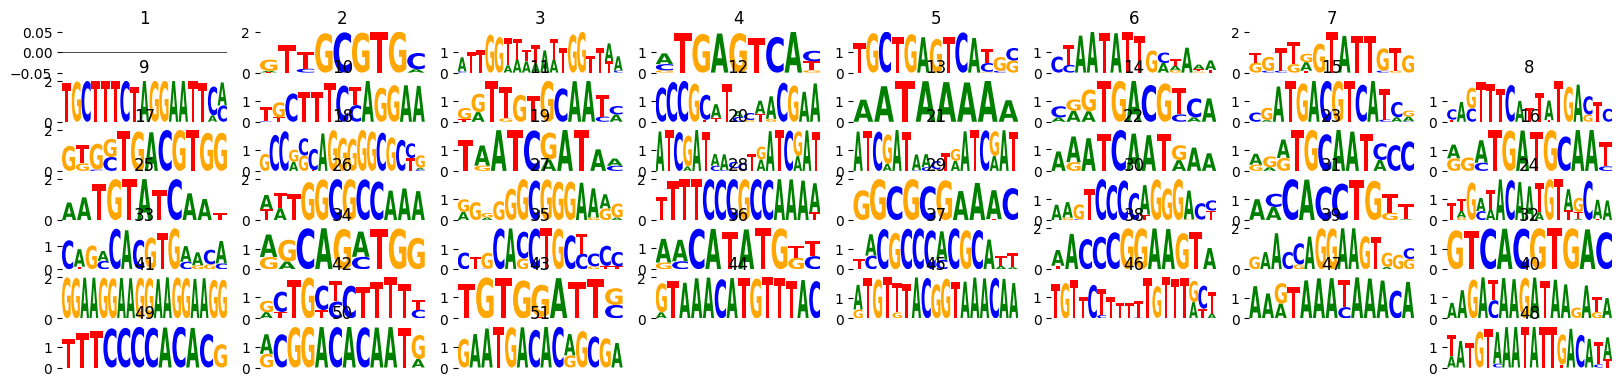

False
True
8
0 out of 52...
8 8 0 (8, 8) (0, 0) 1
8 8 1 (8, 8) (0, 1) 1
8 8 2 (8, 8) (0, 2) 1
8 8 3 (8, 8) (0, 3) 1
8 8 4 (8, 8) (0, 4) 1
8 8 5 (8, 8) (0, 5) 1
8 8 6 (8, 8) (0, 6) 1
8 8 7 (8, 8) (1, 7) 1
8 8 0 (8, 8) (1, 0) 1
10 out of 52...
8 8 1 (8, 8) (1, 1) 1
8 8 2 (8, 8) (1, 2) 1
8 8 3 (8, 8) (1, 3) 1
8 8 4 (8, 8) (1, 4) 1
8 8 5 (8, 8) (1, 5) 1
8 8 6 (8, 8) (1, 6) 1
8 8 7 (8, 8) (2, 7) 1
8 8 0 (8, 8) (2, 0) 1
8 8 1 (8, 8) (2, 1) 1
8 8 2 (8, 8) (2, 2) 1
20 out of 52...
8 8 3 (8, 8) (2, 3) 1
8 8 4 (8, 8) (2, 4) 1
8 8 5 (8, 8) (2, 5) 1
8 8 6 (8, 8) (2, 6) 1
8 8 7 (8, 8) (3, 7) 1
8 8 0 (8, 8) (3, 0) 1
8 8 1 (8, 8) (3, 1) 1
8 8 2 (8, 8) (3, 2) 1
8 8 3 (8, 8) (3, 3) 1
8 8 4 (8, 8) (3, 4) 1
30 out of 52...
8 8 5 (8, 8) (3, 5) 1
8 8 6 (8, 8) (3, 6) 1
8 8 7 (8, 8) (4, 7) 1
8 8 0 (8, 8) (4, 0) 1
8 8 1 (8, 8) (4, 1) 1
8 8 2 (8, 8) (4, 2) 1
8 8 3 (8, 8) (4, 3) 1
8 8 4 (8, 8) (4, 4) 1
8 8 5 (8, 8) (4, 5) 1
8 8 6 (8, 8) (4, 6) 1
40 out of 52...
8 8 7 (8, 8) (5, 7) 1
8 8 0 (8, 8) (5, 0) 1
8 8 1 

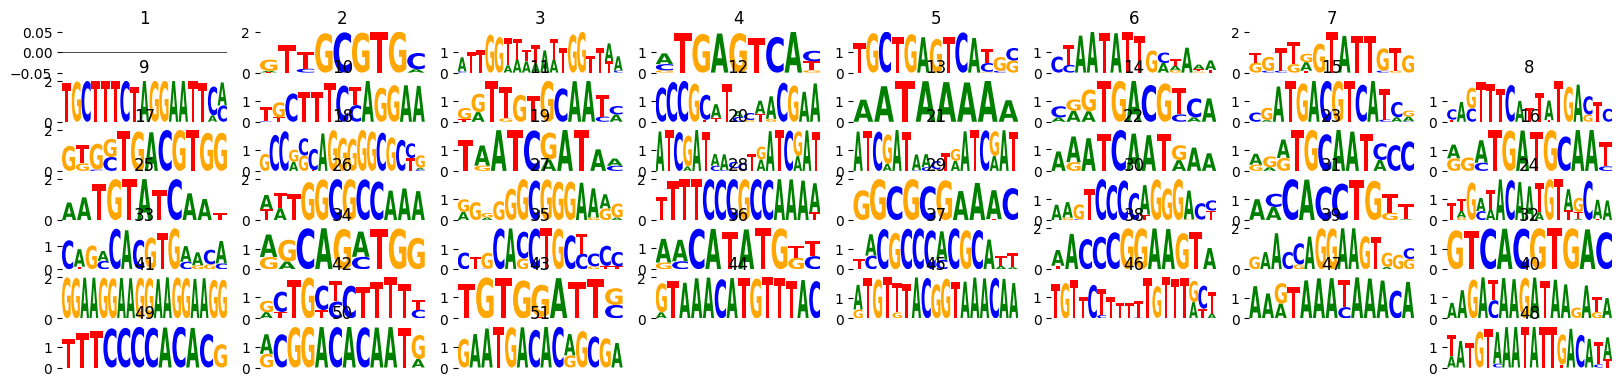

In [35]:
n_cols = int(len(model.binding_modes.conv_mono) ** .5) + 1
for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.conv(model, n_cols=n_cols, show=True, n_rows=n_cols)
    plt.show()


True
False


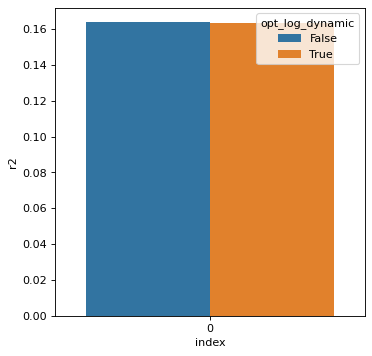

In [36]:
r2_net = None
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_net = r2 if r2_net is None else r2_net.append(r2)

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sns.barplot(data=r2_net, x='index', y='r2', hue='opt_log_dynamic')
plt.show()

In [34]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

AttributeError: 'SelexModule' object has no attribute 'conn_sparse'

In [ ]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [ ]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

Text(0.5, 7.555555555555548, 'dynamic score (normalized)')

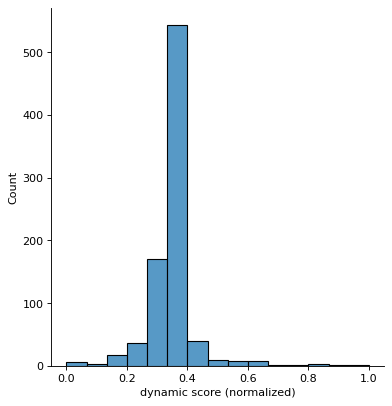

In [ ]:
ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > dynamic_score.quantile(.66), 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > dynamic_score.quantile(.95), 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score, bins=15)
plt.xlabel('dynamic score (normalized)')


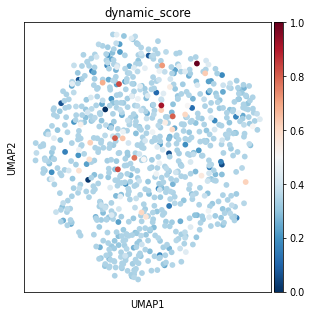

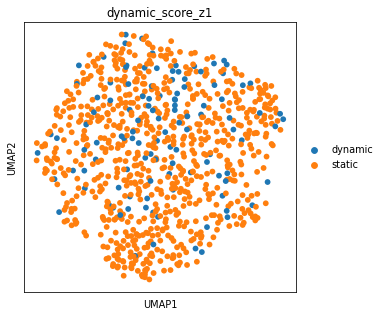

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 70
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [ ]:
ad.obs['dynamic_score_z1']

index
cellranger-arc201_count_dae7bef086560538e47878293f38b2c6#AGGGCTACACAACCTA-1                                                                                           dynamic
cellranger-arc201_count_dae7bef086560538e47878293f38b2c6#CGCATTTGTTTGGGTA-1                                                                                            static
cellranger-arc201_count_dae7bef086560538e47878293f38b2c6#CAGGTTTAGGCTAATC-1                                                                                           dynamic
cellranger-arc201_count_dae7bef086560538e47878293f38b2c6#GTCATCCTCAAGCGCC-1                                                                                           dynamic
cellranger-arc201_count_dae7bef086560538e47878293f38b2c6#AGTCAGGCAGCACGTT-1                                                                                            static
                                                                                                                            

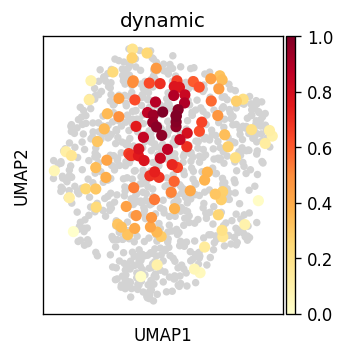

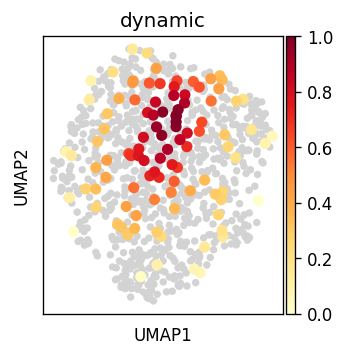

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 120

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [ ]:
sc.set_figure_params()

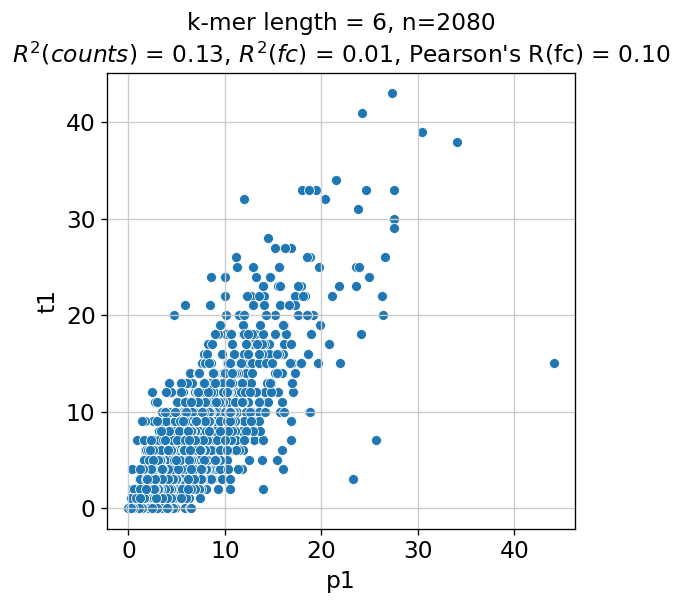

{'r2_counts': 0.12547228137146793,
 'r2_foldchange': -0.03025616672286513,
 'r2_enr': -0.0759225318704746,
 'r2_fc': 0.010970165687432873,
 'pearson_foldchange': 0.104738558742389}

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 60})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=6)


In [ ]:
umap = ad.obsm['X_umap'].copy()
umap = np.sort(umap, 0)

x = umap[:,0]
y = umap[:,1]
X, Y = np.meshgrid(x, y)

n_points = x.shape[0]
# x-component to the right
u = np.ones((n_points, n_points))
# y-component zero
v = np.zeros((n_points, n_points))

In [ ]:
D.shape

torch.Size([850, 850])

In [ ]:
import scvelo as scv

In [ ]:
ad.shape

(850, 1263)

In [ ]:
log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
log_act.shape

torch.Size([850, 52])

In [ ]:
train.dataset.mononuc.shape

(1263, 4, 500)

In [ ]:
pred = []
for i, batch in enumerate(train):
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"].to(device)
    # print(i, mononuc.shape)
    b = batch["batch"].to(device) if "batch" in batch else None
    rounds = batch["rounds"].to(device) if "rounds" in batch else None
    countsum = batch["countsum"].to(device) if "countsum" in batch else None
    seq = batch["seq"] if "seq" in batch else None
    residues = batch["residues"].to(device) if "residues" in batch else None
    if residues is not None and train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                  "residues": residues}
    elif residues is not None:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
    elif train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
    else:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

    inputs['scale_countsum'] = model.datatype == 'selex'
    output = model(**inputs, use_conn=False)

    output = output.cpu().detach().numpy()
    print('here...')
    print(output.shape)

    print(output.sum())
    pred.append(output)

pred = np.concatenate(pred).T
ad.layers['velocity'] = pred
ad.layers['counts'] = ad.X

here...
(512, 850)
18259.0
here...
(512, 850)
14538.001
here...
(239, 850)
4946.9995


In [ ]:
ad.layers['counts']

<850x1263 sparse matrix of type '<class 'numpy.float32'>'
	with 20642 stored elements in Compressed Sparse Row format>

(array([3236., 8858., 4804., 1680.,  860.,  540.,  338.,  294.,  186.,
        1856.]),
 array([2.80259693e-45, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

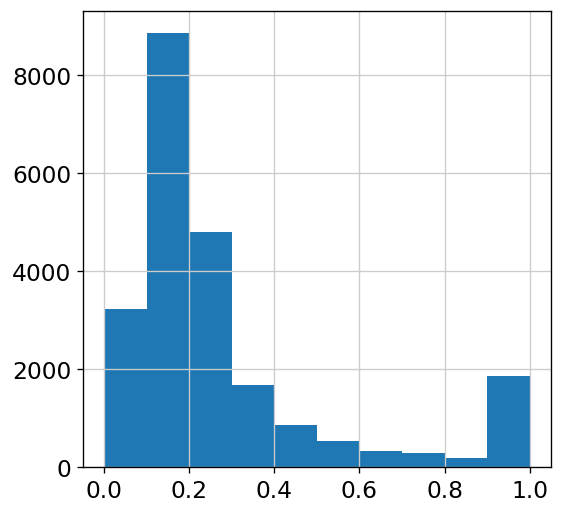

In [ ]:
plt.hist(model.selex_module.conn_sparse.values().detach().cpu().numpy())

In [ ]:
pred.shape

(850, 1263)

In [ ]:
ad.shape

(850, 1263)

In [ ]:
sc.pp.neighbors(ad)

In [ ]:
# ad.layers['log_act'] = dyn_umap.X
# ad.layers['counts'] = ad.X
scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')

computing velocity graph (using 1/16 cores)


  0%|          | 0/850 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
ad.obs['site_id'].value_counts()

AT9-BRA-4-FO-4     82
AT9-BRA-4-FO-3     53
AT6-BRA-3-FO-4     51
AT5-BRA-5-FO-3     50
AT9-BRA-4-FO-2     44
AT3-BRA-5-FO-3     38
AT6-BRA-3-FO-3     37
AT4-BRA-5-FO-3     36
AT4-BRA-5-FO-4     36
AT10-BRA-5-FO-1    35
AT7-BRA-3-FO-3     34
AT10-BRA-5-FO-4    34
AT4-BRA-5-FO-2     31
AT4-BRA-5-FO-1     31
AT3-BRA-5-FO-1     27
AT10-BRA-5-FO-2    23
AT6-BRA-3-FO-1     22
AT5-BRA-5-FO-2     22
AT5-BRA-5-FO-1     21
AT5-BRA-5-FO-4     19
AT7-BRA-3-FO-1     19
AT9-BRA-4-FO-1     19
AT10-BRA-5-FO-3    19
AT6-BRA-3-FO-2     18
AT3-BRA-5-FO-4     18
AT3-BRA-5-FO-2     17
AT7-BRA-3-FO-4     12
AT7-BRA-3-FO-2      2
Name: site_id, dtype: int64

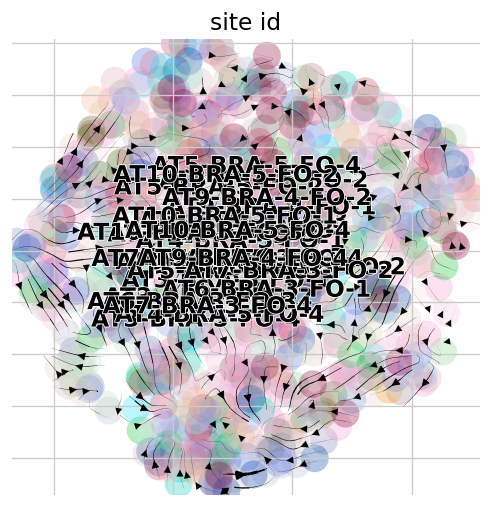

In [ ]:
scv.pl.velocity_embedding_stream(ad, color='site_id') #  X_grid='X_umap', V=V)


In [ ]:
ad.shape

(850, 1263)

In [ ]:
act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
# log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
# log_act


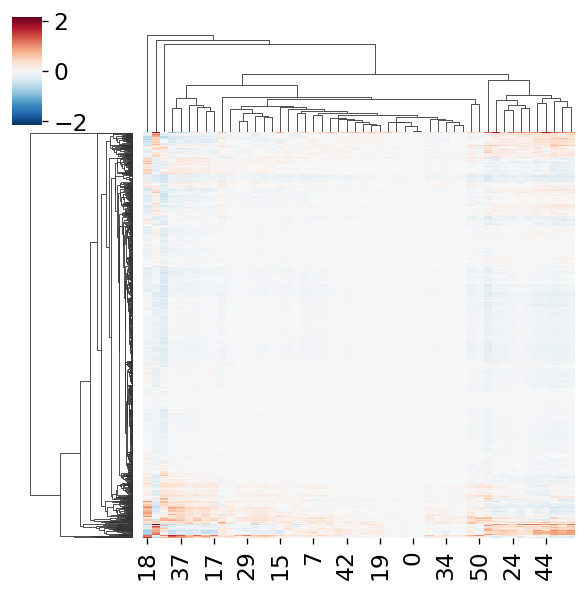

In [ ]:
vmax = act.abs().max()
sns.clustermap(act.detach().cpu().numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

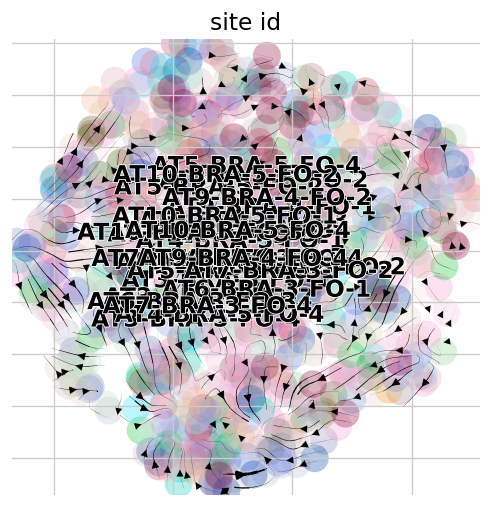

In [ ]:

scv.pl.velocity_embedding_stream(ad, color='site_id') #  X_grid='X_umap', V=V)


In [ ]:
log_act.shape


torch.Size([850, 52])

In [ ]:
ad.shape


(850, 1263)

In [ ]:
log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
log_act = pd.DataFrame(log_act.detach().cpu().numpy())
# log_act.columns = anno['Seed_motif'][2]
log_act.columns = ['intercept', 'dinuc_bias'] + list(anno.head(log_act.shape[1] - 2)['Seed_motif'].values)

log_act.index = ad.obs_names
ad.obsm['mubind_activities'] = log_act
for c in ad.obsm['mubind_activities']:
    ad.obs[c] = ad.obsm['mubind_activities'][c]

Text(0.5, 1.0, 'TF modules (by score)')

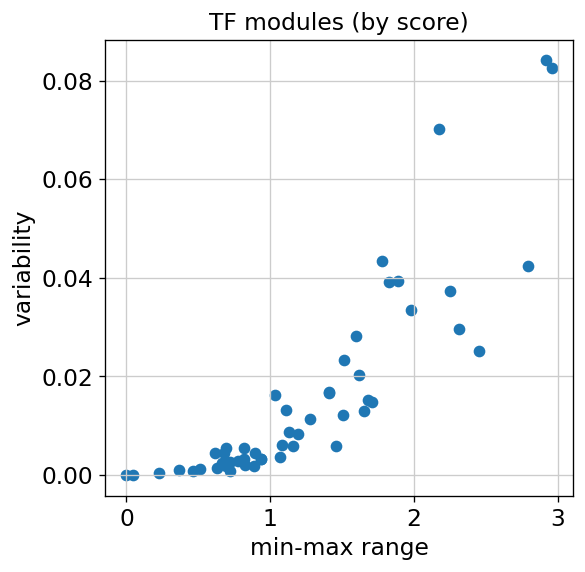

In [ ]:

delta = (log_act.max(axis=0) - log_act.min(axis=0))
var = log_act.var(axis=0)
plt.scatter(delta, var)
plt.xlabel('min-max range')
plt.ylabel('variability')
plt.title('TF modules (by score)')

In [ ]:
scores = pd.concat([delta, var], axis=1)
scores['combined'] = scores.sum(axis=1)
scores.sort_values('combined', ascending=False)
scores['idx'] = np.arange(scores.shape[0])

In [ ]:
scores

,0,1,combined,idx
intercept,0.000159,7.462903e-11,0.000159,0
dinuc_bias,0.048249,7.350048e-06,0.048257,1
AHR_HUMAN.H11MO.0.B,1.069109,3.602836e-03,1.072712,2
AIRE_HUMAN.H11MO.0.C,1.107797,1.316763e-02,1.120964,3
ATF3_MOUSE.H11MO.0.A,0.366860,9.814808e-04,0.367841,4
BACH1_HUMAN.H11MO.0.A,1.191674,8.274385e-03,1.199948,5
Arid5a_MA0602.1,1.652855,1.302148e-02,1.665876,6
ARI5B_HUMAN.H11MO.0.C,0.617079,4.546184e-03,0.621625,7
BATF3_HUMAN.H11MO.0.B,1.677625,1.511458e-02,1.692739,8
BCL6B_C2H2_1,1.828983,3.907131e-02,1.868055,9


In [ ]:
gene_query = 'CTCF'
names_query = anno[anno['Cluster_ID'].isin(set(clu[clu['Motif'].str.contains(gene_query)]['Cluster_ID'].values))]['Seed_motif'].values
names_query


array(['CTCFL_HUMAN.H11MO.0.A'], dtype=object)

In [ ]:
# top_idx = scores.sort_values('combined', ascending=False).head(5).index
# idx_mb_model = scores.sort_values('combined', ascending=False).head(5)['idx'].values
top_idx = scores.head()[2:8].index
idx_mb_model = scores.head()['idx'].values[2:8]

In [ ]:
idx_mb_model

array([2, 3, 4])

In [ ]:
top_idx, idx_mb_model

(Index(['AHR_HUMAN.H11MO.0.B', 'AIRE_HUMAN.H11MO.0.C', 'ATF3_MOUSE.H11MO.0.A'], dtype='object'),
 array([2, 3, 4]))

In [ ]:
# top_idx = [0, 1, 2, 3]

AHR_HUMAN.H11MO.0.B
AIRE_HUMAN.H11MO.0.C
ATF3_MOUSE.H11MO.0.A
0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)


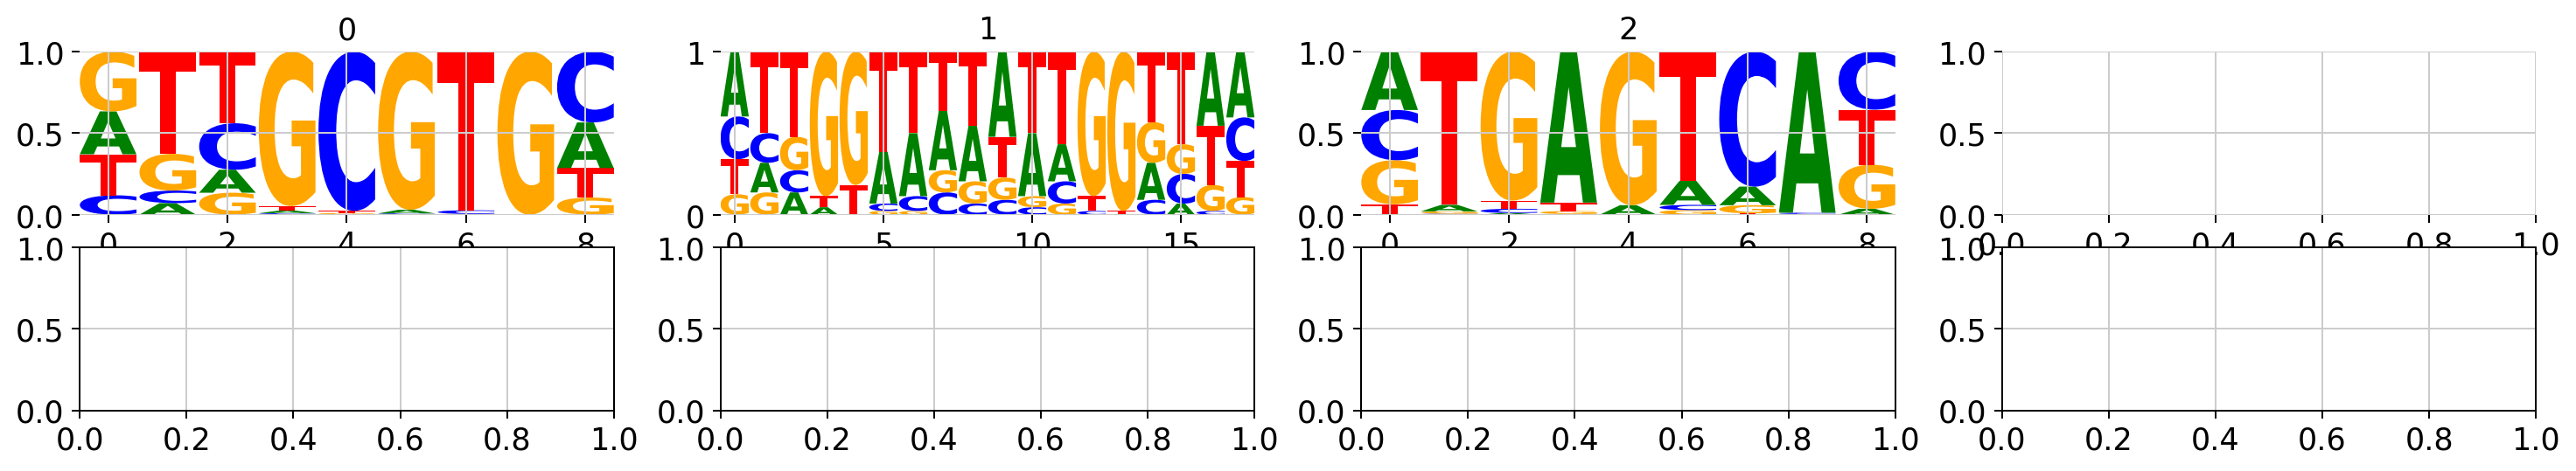

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [20, 3], 'figure.dpi': 90})
for k in top_idx:
    print(k)
mb.pl.conv_mono(weights_list=[pwms_by_name[k] for k in top_idx], n_cols=4, n_rows=2)

0 1 (4, 2)
1 2 (4, 9)
2 3 (4, 18)


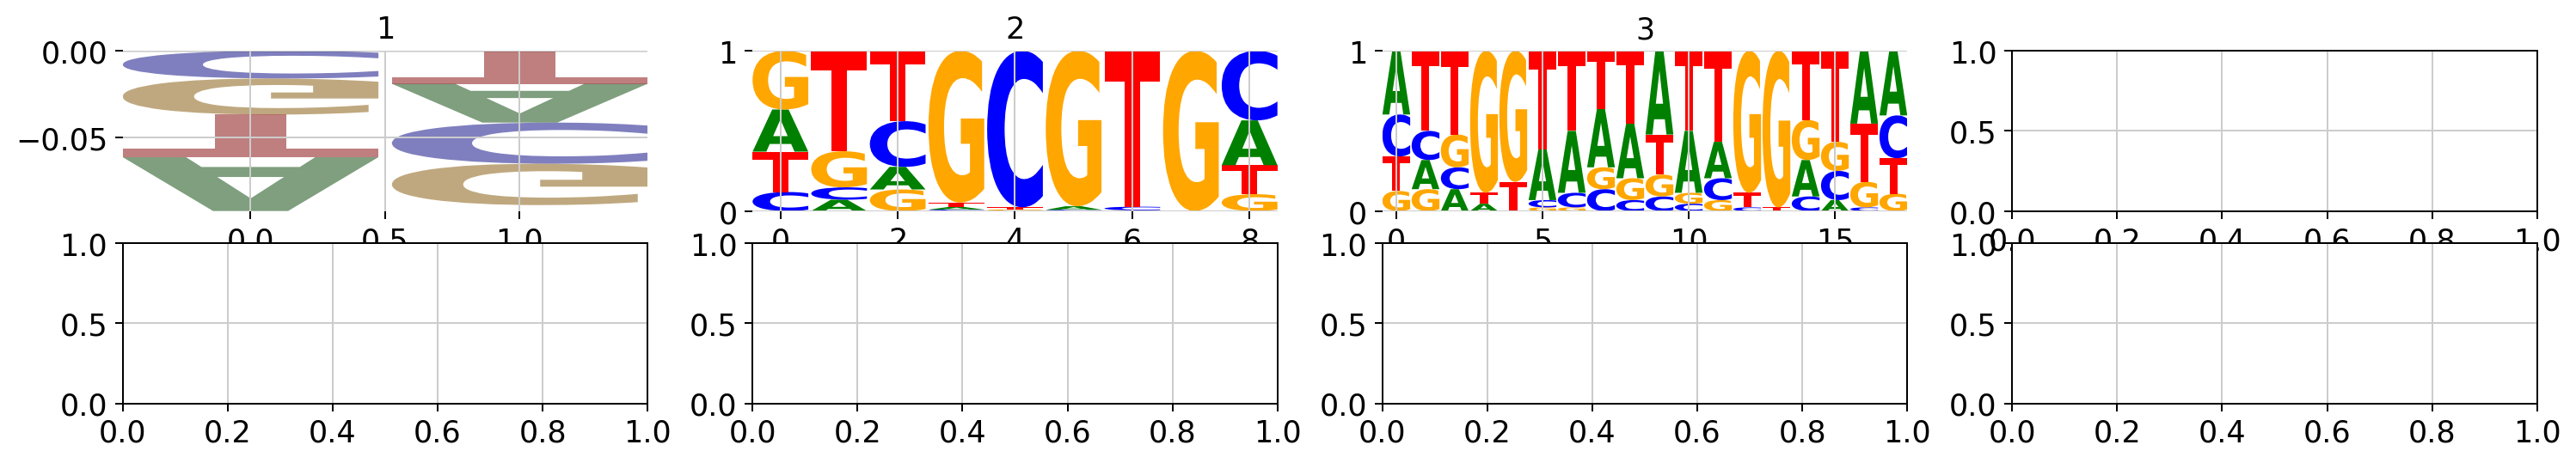

In [ ]:
mb.pl.conv_mono(model, subset=[idx - 1 for idx in idx_mb_model], n_cols=4, n_rows=2)

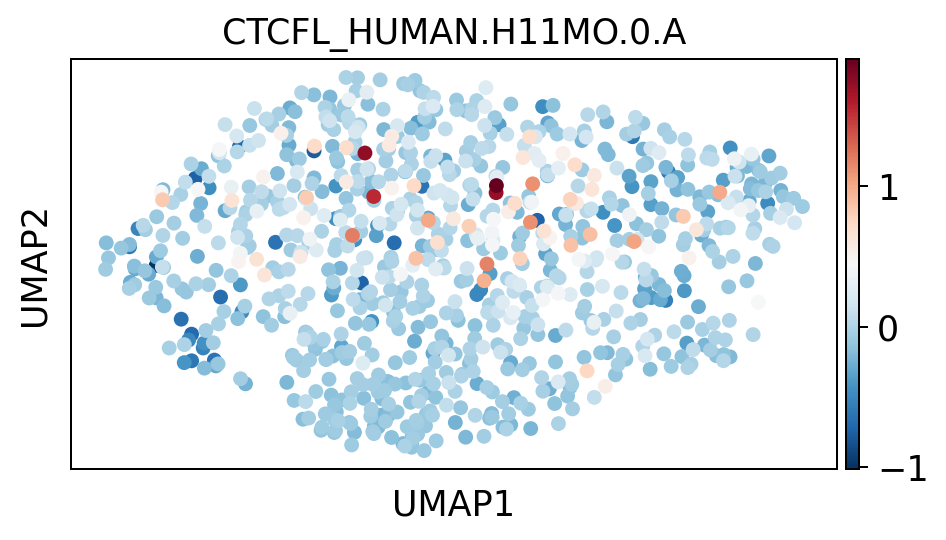

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [6, 3], 'figure.dpi': 90})
sc.pl.umap(ad, color=names_query, cmap='RdBu_r')

AHR_HUMAN.H11MO.0.B
AIRE_HUMAN.H11MO.0.C
ATF3_MOUSE.H11MO.0.A
0 1 (4, 2)
1 2 (4, 9)
2 3 (4, 18)


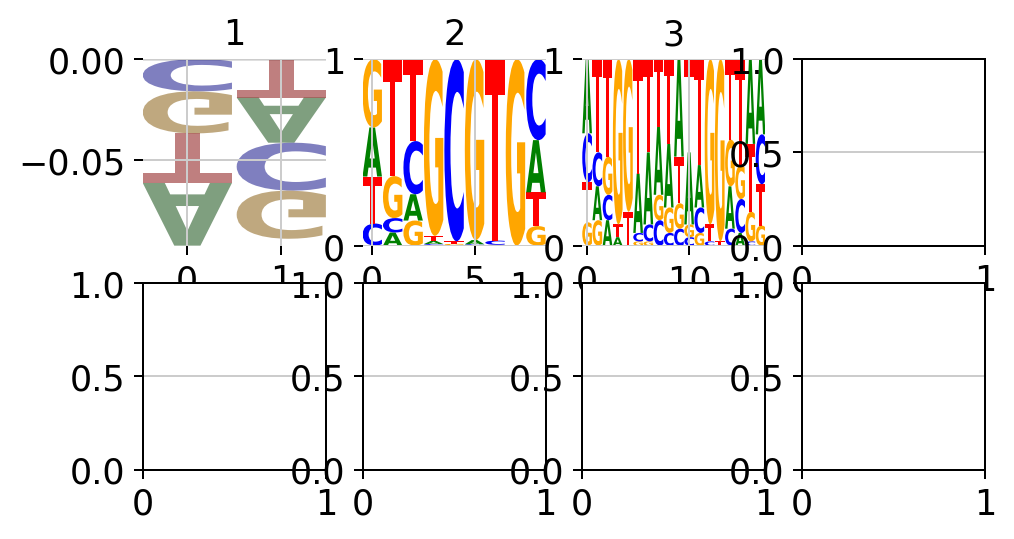

In [ ]:
for k in top_idx:
    print(k)


# model
mb.pl.conv_mono(model, subset=[idx - 1 for idx in idx_mb_model], n_cols=4, n_rows=2)


In [ ]:
pwms_show = [np.log2((pwms_by_name[k] + 1e-3) / (0.25) + 1e-3) for k in pwms_by_name][:20]

In [ ]:
for i, pwm in enumerate(pwms_show):
    pwm[pwm < 0] = 0

0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)
3 3 (4, 13)
4 4 (4, 14)
5 5 (4, 13)
6 6 (4, 17)
7 7 (4, 17)
8 8 (4, 13)
9 9 (4, 12)
10 10 (4, 15)
11 11 (4, 8)
12 12 (4, 11)
13 13 (4, 14)
14 14 (4, 12)
15 15 (4, 12)
16 16 (4, 17)
17 17 (4, 10)


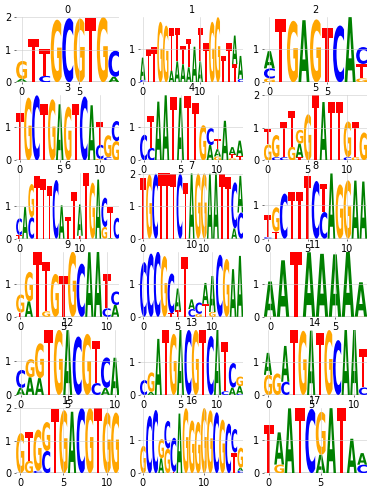

In [ ]:
# original pwms
mb.pl.set_rcParams({'figure.figsize': [9, 12], 'figure.dpi': 25})
mb.pl.conv_mono(weights_list=pwms_show,
                n_cols=3, n_rows=6)

0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)


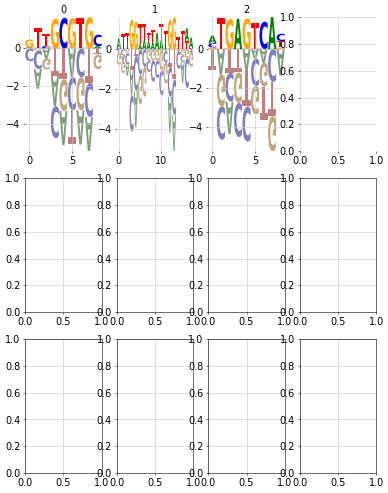

In [ ]:
mb.pl.conv_mono(weights_list=[np.log2((pwms_by_name[k] + .1) / (0.25 + .1)) for k in top_idx], n_cols=4, n_rows=3)

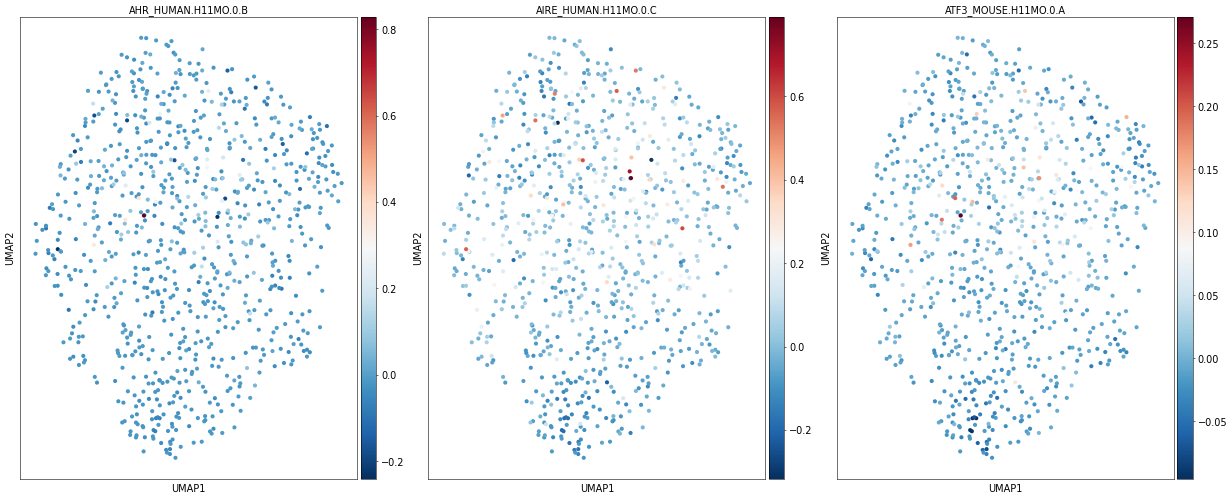

In [ ]:
sc.pl.umap(ad, color=top_idx, cmap='RdBu_r')
